In [21]:
from google.oauth2.credentials import Credentials
from google.oauth2 import service_account
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io

import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from tensorflow.keras.applications import efficientnet_v2
import random
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
import os
import torch



In [22]:
# Set global seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.manual_seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

os.environ['PYTHONHASHSEED'] = str(SEED)
tf.keras.utils.set_random_seed(SEED)

# # 2. Environment variables untuk memaksa deterministic operations
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'


tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

tf.keras.mixed_precision.set_global_policy('float32')

In [23]:
# Tentukan API Scope
SCOPES = ['https://www.googleapis.com/auth/drive']
SERVICE_ACCOUNT_FILE = 'ee-grogol-fecca817c40d.json'
PARENT_FOLDER_ID = ''

# Tentukan kredensial menggunakan file Service Account
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES)

# Membangun layanan Google Drive
service = build('drive', 'v3', credentials=credentials)

# Contoh untuk mengambil daftar file dari Google Drive
results = service.files().list(pageSize=10, fields="files(id, name)").execute()
items = results.get('files', [])

if not items:
    print('Tidak ada file ditemukan.')
else:
    print('Daftar file:')
    for item in items:
        print(f'{item["name"]} ({item["id"]})')


Daftar file:
Sentinel2_Samples_LC_Grogol_2023_S2_fix.csv (1oyLnTz-rJtQmM9KgXV7u1H9twaHhuc25)
testing.csv (1x7z7d2c0uB_T7YWg3gCe1Pdi4fbuXMST)
Sentinel2_Grogol_2023.tif (1sKH9zFclSPbdPjdaq9omCubA1-xwU7eM)
Sentinel2_Grogol_2023_84_2.tif (12sPDmPrks-dQZin9O3opHMp37wuYkbIs)
Sentinel2_Samples_LC_Grogol_2023_S2_84_2.csv (1sgdySkXltWxDZOuBMNjOhCiwi4ahPnUT)
Sentinel2_Grogol_2023_val82.tif (1xDCb6ORms_p1TmamA9GHDe1RXwYCJEal)
Sentinel2_Samples_LC_Grogol_2023_S2_val82.csv (1PmYNQm3g0xTn2DHE7Oh1xiqkNbCw6ru9)
Sentinel2_Samples_LC_Grogol_2023_S2_val84.csv (1al-pJCswZw2fr0qYxtv3SSchjUXel5NW)
Sentinel2_Grogol_2023_val84.tif (1cOP_RxIKooyUvVatNNiGl0k0_B9RC6Xp)
DL (1m0ofC_Sew20EqxjgrUZ-TAcPH0yf5CFX)


In [24]:
csv_filename = 'Sentinel2_Samples_LC_Grogol_2023_S2_fix.csv'
tif_filename = 'Sentinel2_Grogol_2023.tif'

In [25]:
# Fungsi untuk mencari ID file berdasarkan nama
def get_file_id(file_name):
    # Mencari file berdasarkan nama
    results = service.files().list(
        q=f"name = '{file_name}'",  # Menyesuaikan nama file yang dicari
        fields="files(id, name)"
    ).execute()

    items = results.get('files', [])
    
    if not items:
        print(f"File dengan nama '{file_name}' tidak ditemukan.")
        return None
    else:
        # Mengembalikan ID file pertama yang ditemukan
        return items[0]['id']

# Mencari ID untuk file CSV dan TIFF
csv_file_id = get_file_id(csv_filename)
tif_file_id = get_file_id(tif_filename)

In [26]:
# Mengunduh file CSV
request_csv = service.files().get_media(fileId=csv_file_id)
csv_file = io.BytesIO()  # Menyimpan file CSV dalam memori
downloader_csv = MediaIoBaseDownload(csv_file, request_csv)

# Mengunduh file TIFF
request_tif = service.files().get_media(fileId=tif_file_id)
tif_file = io.BytesIO()  # Menyimpan file TIFF dalam memori
downloader_tif = MediaIoBaseDownload(tif_file, request_tif)

done = False
while done is False:
    status, done = downloader_csv.next_chunk()
    status, done = downloader_tif.next_chunk()

# Menyimpan CSV ke variabel SAMPLE_PATH
csv_file.seek(0)  # Reset pointer ke awal file
SAMPLE_PATH = pd.read_csv(csv_file)

# Menyimpan TIFF ke variabel IMAGE_PATH
tif_file.seek(0)
IMAGE_PATH = rasterio.MemoryFile(tif_file.read())

In [27]:
# Parameter
FEATURES = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 4
# CLASSES = [1, 2, 3, 4, 5, 6]
# PALETTE = ['#87CEFA', '#D2B48C', '#008080', '#FFE31A', '#FA812F', '#3B1E54']
CLASSES = [1, 2, 3, 4]
PALETTE = ['#87CEFA', '#D2B48C', '#008080', '#FFE31A']

c:\Users\fajar\AppData\Local\Programs\Python\Python310\lib\site-packages\earthpy\spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


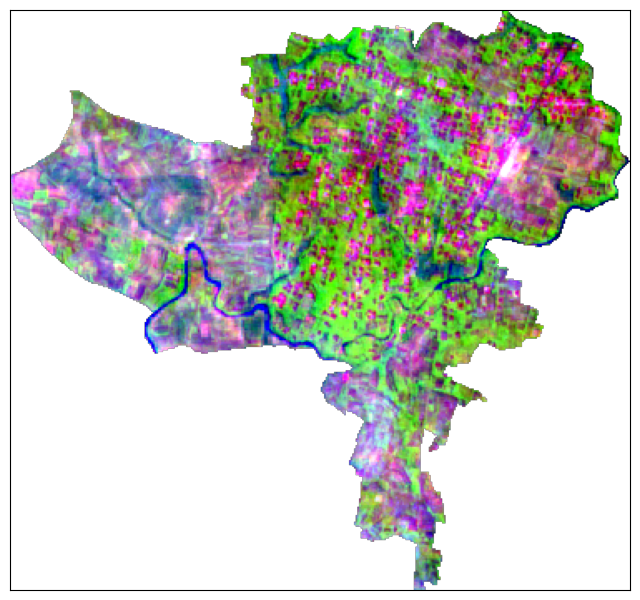

<Axes: >

In [28]:
# Load image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [11, 8, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

In [29]:
samples = SAMPLE_PATH.sample(frac = 1) # Shuffle data
samples

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12,EVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
4037,0.11300,0.12720,0.11460,0.15345,0.27220,0.29715,0.30420,0.32225,0.24220,0.16610,0.414227,0.293642,0.113470,-0.410292,-0.113470,0.186383,157,4,train
4245,0.11890,0.13570,0.11860,0.17600,0.29250,0.32965,0.34120,0.36245,0.25760,0.15950,0.479308,0.362892,0.139613,-0.430908,-0.139613,0.235195,155,4,train
1966,0.08035,0.11220,0.06510,0.16425,0.31685,0.36390,0.38080,0.39635,0.22195,0.11125,0.675280,0.547810,0.263542,-0.544828,-0.263542,0.332233,168,3,train
4762,0.10040,0.11100,0.10265,0.15430,0.23135,0.26325,0.25975,0.28480,0.23080,0.14935,0.349842,0.269861,0.059015,-0.401214,-0.059015,0.214258,166,4,train
1374,0.08720,0.09200,0.09165,0.13805,0.19910,0.22920,0.21110,0.26470,0.28195,0.21620,0.269761,-0.011935,-0.143697,-0.392940,0.143697,0.131988,163,2,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.07080,0.09715,0.05935,0.14285,0.32630,0.37780,0.34860,0.40460,0.22400,0.11740,0.616107,0.496137,0.217604,-0.564105,-0.217604,0.312244,167,3,test
5191,0.09790,0.12200,0.09275,0.15785,0.29880,0.33235,0.30990,0.35315,0.23060,0.14515,0.479508,0.362048,0.146716,-0.435054,-0.146716,0.227412,145,4,train
5226,0.11250,0.12930,0.10770,0.16610,0.28665,0.33635,0.33360,0.36080,0.22455,0.12890,0.497117,0.442595,0.195378,-0.441348,-0.195378,0.270618,149,4,train
5390,0.12820,0.14320,0.12570,0.17820,0.29880,0.34925,0.34920,0.37775,0.24905,0.15135,0.489316,0.395265,0.167405,-0.418359,-0.167405,0.244006,156,4,train


In [30]:
# Split into train and test based on column
train = samples[samples['sample'] == 'train']
test = samples[samples['sample'] == 'test']

# Split between features and label
train_features = train[FEATURES]
train_label = train[LABEL]
test_features = test[FEATURES]
test_label = test[LABEL]

In [31]:
# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES + 1)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (4886, 17, 1)
Test features: (1063, 17, 1)
Train label: (4886, 5)
Test label: (1063, 5)


In [32]:
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, 
    Dense, GlobalMaxPooling1D, BatchNormalization, AveragePooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
import tensorflow as tf

In [33]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 128
drop = 0.2
kernel = 2
pool = 2

# Make sequential model
model = Sequential([
    Input(input_shape),
    # Tambahkan BatchNormalization
    Conv1D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    AveragePooling1D(2),
    
    Conv1D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv1D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    AveragePooling1D(2),
    
    GlobalAveragePooling1D(),
    
    # Tambahkan layer dense lebih kompleks
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(N_CLASSES + 1, activation='softmax')
])
model.summary()

# Train the model
model.compile(
    optimizer='Adam',
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

stop = EarlyStopping(
    monitor='loss',
    patience=50
)

best_model_path = 'best_model.keras'

checkpoint = ModelCheckpoint(
    best_model_path,
    monitor='val_accuracy', 
    save_best_only=True,  
    verbose=1 
)

# Train the model dengan ModelCheckpoint
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=64,
    callbacks=[stop, checkpoint], 
    epochs=150,
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 15, 64)            256       
                                                                 
 batch_normalization (BatchN  (None, 15, 64)           256       
 ormalization)                                                   
                                                                 
 conv1d_18 (Conv1D)          (None, 13, 64)            12352     
                                                                 
 batch_normalization_1 (Batc  (None, 13, 64)           256       
 hNormalization)                                                 
                                                                 
 average_pooling1d (AverageP  (None, 6, 64)            0         
 ooling1D)                                                       
                                                      

In [34]:
# Memuat model terbaik
best_model = keras.models.load_model('best_model.keras')
# Menampilkan hasil akurasi dan akurasi validasi dari training
history = pd.DataFrame(result.history)
# Menampilkan epoch dengan akurasi validasi terbaik
best_epoch = history['val_accuracy'].idxmax() + 1  # Menambahkan 1 untuk mendapatkan nomor epoch yang benar
best_val_accuracy = history['val_accuracy'].max()
best_train_accuracy = history['accuracy'][best_epoch - 1]

print(f"Model terbaik ditemukan pada epoch ke-{best_epoch} dengan:")
print(f"Accuracy: {best_train_accuracy:.4f}")
print(f"Validation Accuracy: {best_val_accuracy:.4f}")


Model terbaik ditemukan pada epoch ke-38 dengan:
Accuracy: 0.9054
Validation Accuracy: 0.9031


In [35]:
# Predict test data
prediction = np.argmax(best_model.predict(test_input), 1).flatten()
label = np.argmax(test_output, 1).flatten()

# Classification report
print(classification_report(label, prediction, digits=4))

34/34 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           1     1.0000    0.9205    0.9586        88
           2     0.8188    0.8531    0.8356       143
           3     0.8995    0.9268    0.9129       396
           4     0.9176    0.8945    0.9059       436

    accuracy                         0.9031      1063
   macro avg     0.9090    0.8987    0.9033      1063
weighted avg     0.9044    0.9031    0.9034      1063



In [36]:
kappa_score = cohen_kappa_score(label, prediction)

print(f"Cohen's Kappa: {kappa_score:.4f}")

Cohen's Kappa: 0.8549


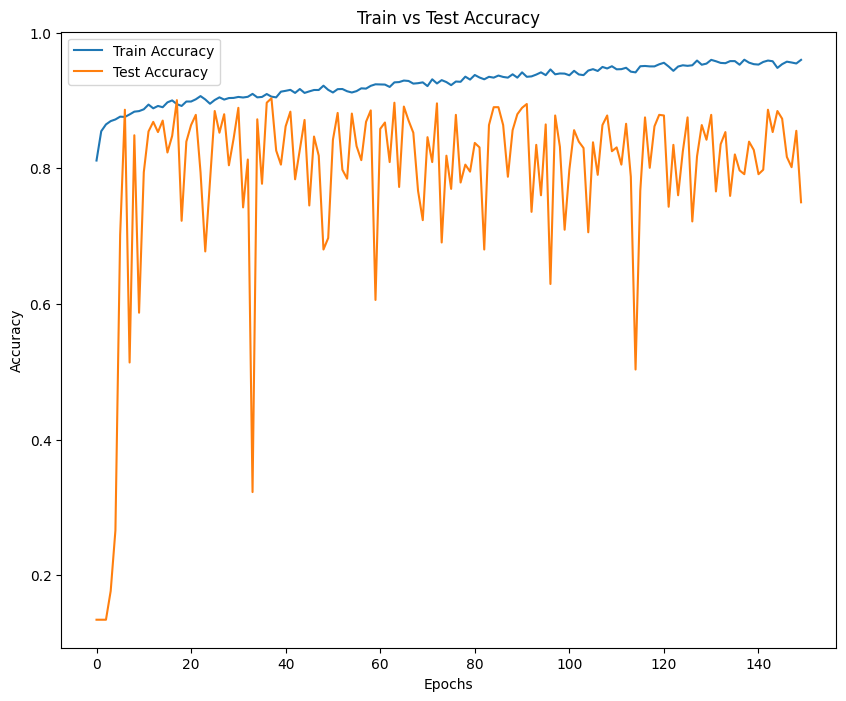

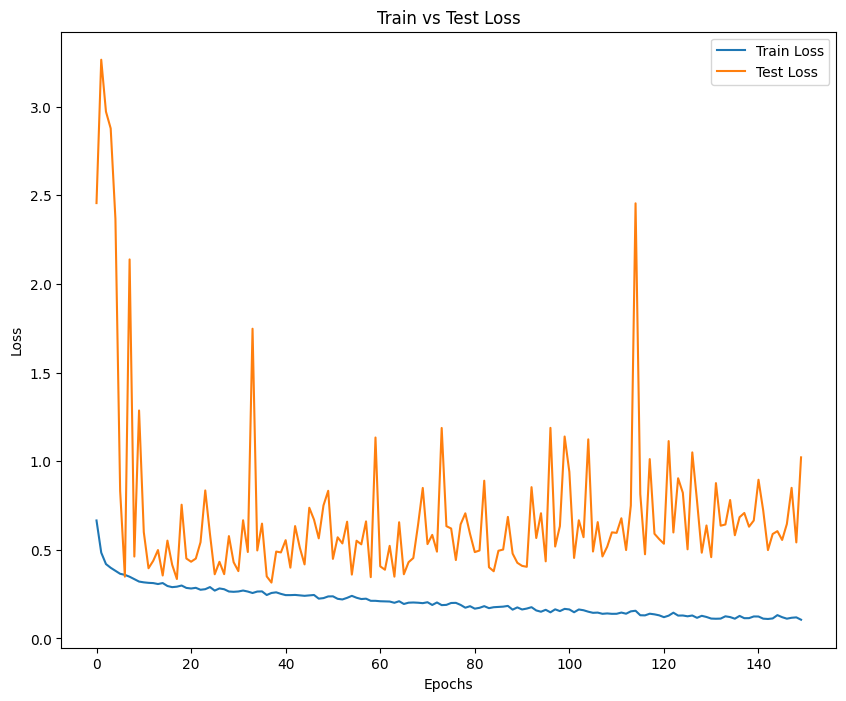

In [37]:
history = pd.DataFrame(result.history)

# Plot Akurasi
plt.figure(figsize=(10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label='Train Accuracy')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 8))
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label='Train Loss')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()


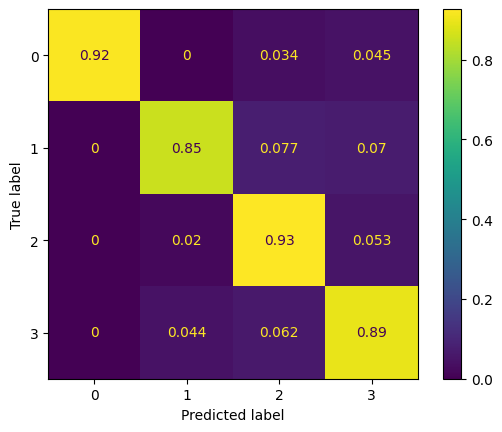

In [38]:
# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
cm = ConfusionMatrixDisplay(cm)
cm.plot()

<Axes: >

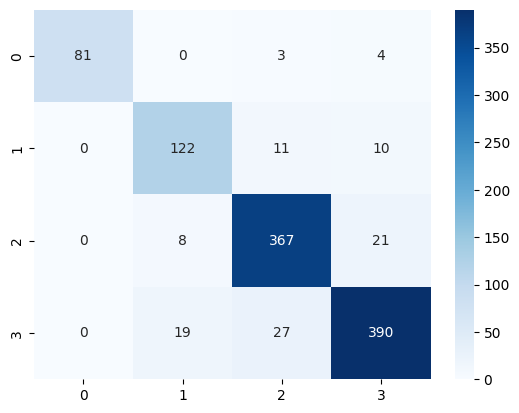

In [39]:
cm = confusion_matrix(test_label, prediction)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

In [40]:
from sklearn.metrics import cohen_kappa_score

# Hitung Cohen's Kappa
kappa_score = cohen_kappa_score(label, prediction)
print(f"Cohen's Kappa: {kappa_score:.4f}")

Cohen's Kappa: 0.8549


In [41]:
image.indexes

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19)

In [42]:
for i in range(1, image.count + 1):
    band_description = image.descriptions[i - 1]
    print(f"Band {i}: {band_description if band_description else 'Tidak ada deskripsi'}")


Band 1: B1
Band 2: B2
Band 3: B3
Band 4: B4
Band 5: B5
Band 6: B6
Band 7: B7
Band 8: B8
Band 9: B8A
Band 10: B9
Band 11: B11
Band 12: B12
Band 13: EVI
Band 14: NBR
Band 15: NDMI
Band 16: NDWI
Band 17: NDBI
Band 18: NDBaI
Band 19: elevation


In [21]:
# FEATURES = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 
# 'B12', 'EVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']

2/2 [==============================] - 4s 1s/step


(-0.5, 372.5, 348.5, -0.5)

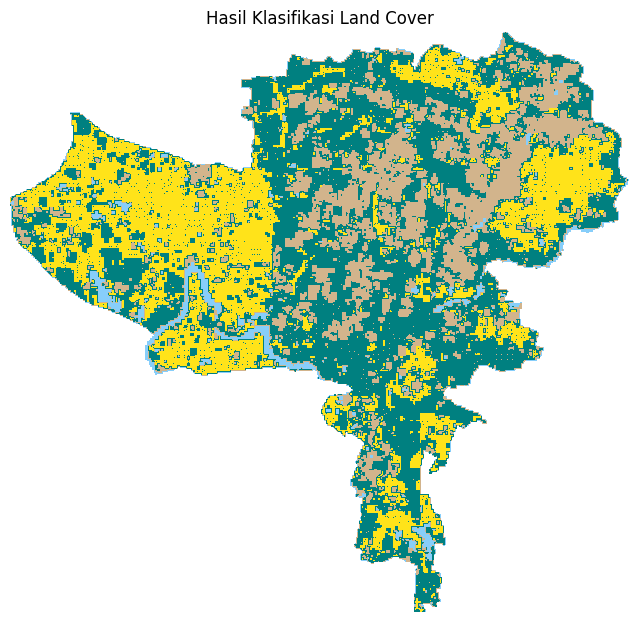

In [43]:
use_band = [2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19]
# Predict image using the model
image_input = []
for x in use_band:
  image_input.append(image.read(x))
image_input = reshape_input(np.stack(image_input).reshape(17, -1).T)

# Predict
prediction = best_model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
# cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
# ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)

cmap, norm = from_levels_and_colors([-1] + CLASSES, ['#FFFFFF'] + PALETTE, extend='max')
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(prediction, cmap=cmap, norm=norm)
fig.colorbar(im, ax=ax).remove()
plt.title("Hasil Klasifikasi Land Cover")
plt.axis('off')

In [44]:
import numpy as np
import rasterio

# Fungsi untuk menghitung luas wilayah berdasarkan klasifikasi
def calculate_area(classified_image, classes, pixel_size):
    """
    Menghitung luas wilayah untuk kelas-kelas tertentu dalam citra yang telah diklasifikasikan.

    Parameters:
    - classified_image: array 2D dari hasil klasifikasi (dengan nilai kelas pada setiap piksel)
    - classes: list dari kelas-kelas yang ingin dihitung luasnya
    - pixel_size: ukuran piksel (dalam unit spasial, misalnya meter persegi per piksel)

    Returns:
    - Dictionary dengan luas wilayah untuk setiap kelas (dalam satuan area)
    """
    area_dict = {}

    # Loop untuk setiap kelas
    for cls in classes:
        # Hitung jumlah piksel dengan kelas tertentu
        pixel_count = np.sum(classified_image == cls)

        # Hitung luas dengan mengalikan jumlah piksel dengan ukuran piksel
        area = pixel_count * pixel_size

        # Simpan hasilnya dalam dictionary
        area_dict[cls] = area

    # Menghitung total luas berdasarkan kelas-kelas yang diinginkan
    total_area = sum(area_dict.values())

    # Menambahkan total luas ke dictionary
    area_dict['Total'] = total_area

    return area_dict

# Misalkan 'prediction' adalah hasil klasifikasi dari model yang telah diprediksi
# dan 'image' adalah objek rasterio untuk citra input

# Resolusi spasial (misalnya, 10 meter per piksel)
pixel_size = 10 * 10  # jika resolusi 10m x 10m per piksel, maka 100 m2 per piksel

# Kelas yang ingin dihitung luasnya
classes = [1, 2, 3, 4]  # Contoh kelas yang ada

# Menggunakan citra klasifikasi yang sudah ada
classified_image = prediction  # 'prediction' sudah berupa hasil klasifikasi 2D

# Menghitung luas wilayah untuk setiap kelas
area_per_class = calculate_area(classified_image, classes, pixel_size)

# Menampilkan hasil luas wilayah untuk setiap kelas
for cls, area in area_per_class.items():
    print(f"Luas wilayah untuk kelas {cls}: {area} meter persegi")


Luas wilayah untuk kelas 1: 173700 meter persegi
Luas wilayah untuk kelas 2: 1010400 meter persegi
Luas wilayah untuk kelas 3: 2020800 meter persegi
Luas wilayah untuk kelas 4: 2636200 meter persegi
Luas wilayah untuk kelas Total: 5841100 meter persegi
